In [1]:
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import tables

2025-03-03 21:28:22.428200: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-03 21:28:23.211313: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-03 21:28:24.607252: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-03-03 21:28:31.601699: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-03 21:28:32.014616: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-03 21:28:32.014714: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
H = 1024          
num_points = 1024     
dz = 1
num_modes = 16         
f_value = 100        
batch_size = 64

In [4]:
def get_name(prefix: str | None = None, suffix: str | None = None, sep: str = "."):
    return prefix and suffix and prefix + sep + suffix

In [60]:
class CustomLoss(keras.layers.Layer):
    def __init__(self, f_val=100.0, H=500.0, num_points=256, num_modes=16, **kwargs):
        super().__init__(**kwargs)
        self.f_val = f_val
        self.H = H
        self.num_points = num_points
        self.num_modes = num_modes
        
    def call(self, inputs):

        envir_input, modes_input, waves_input, modes, wave_numbers = inputs
        c = envir_input[..., 1]
        rho = envir_input[..., 2]
        omega = 2 * np.pi * self.f_val
        K = omega / c
        dz = 1

        # Лосс для уравнения
        phi_pad = keras.ops.pad(modes, [[0,0], [0,0], [1,1]], mode='reflect')
        phi_der = (phi_pad[:, :, 2:] - 2 * phi_pad[:, :, 1:-1] + phi_pad[:, :, :-2]) / (dz ** 2)
        
        K = keras.ops.expand_dims(keras.ops.square(K), axis=1)
        K = keras.ops.repeat(K, self.num_modes, axis=1)
        
        wn = keras.ops.expand_dims(keras.ops.square(wave_numbers), axis=-1)
        wn = keras.ops.repeat(wn, self.num_points, axis=-1)
        
        loss_equation = keras.ops.mean(keras.ops.square(phi_der + (K - wn) * modes))
        
        # Лосс для граничных условий
        # Равенство нулю для первой и последней точки
        loss_boundary = keras.ops.mean(keras.ops.square(modes[:, :, 0])) + keras.ops.mean(keras.ops.square(modes[:, :, -1]))
        
        # Непрерывность производной на границе
        water_mask = keras.ops.cast(rho == 1.0, 'int32')
        border_idx = keras.ops.sum(water_mask, axis=1) - 1
        border_idx_expanded = keras.ops.expand_dims(border_idx, axis=-1)
        
        batch_size = keras.ops.shape(modes)[0]
        positions = keras.ops.arange(self.num_points)
        positions = keras.ops.expand_dims(positions, axis=0)
        
        mask_border = keras.ops.cast(positions == border_idx_expanded, 'float32')
        mask_border = keras.ops.expand_dims(mask_border, axis=1)
        phi_border = keras.ops.sum(modes * mask_border, axis=-1)
        
        mask_bottom = keras.ops.cast(positions == (border_idx_expanded + 1), 'float32')
        mask_bottom = keras.ops.expand_dims(mask_bottom, axis=1)
        phi_bottom = keras.ops.sum(modes * mask_bottom, axis=-1)
        
        mask_left = keras.ops.cast(positions == (border_idx_expanded - 1), 'float32')
        mask_left = keras.ops.expand_dims(mask_left, axis=1)
        phi_left = keras.ops.sum(modes * mask_left, axis=-1)
        
        deriv_left = (phi_border - phi_left) / dz
        deriv_right = (phi_bottom - phi_border) / dz
        loss_border = keras.ops.mean(keras.ops.square(deriv_left - 0.5 * deriv_right))
        
        # Ортонормированность модовых функций
        weighted_modes = modes / keras.ops.sqrt(keras.ops.expand_dims(rho, axis=1))
        
        matmul_modes = keras.ops.matmul(weighted_modes, keras.ops.transpose(weighted_modes, [0, 2, 1])) * dz
        
        identity = keras.ops.eye(self.num_modes)
        identity_matrix = keras.ops.expand_dims(identity, 0)
        identity_matrix = keras.ops.repeat(identity_matrix, keras.ops.shape(matmul_modes)[0], axis=0)
        
        orthonorm_row = keras.ops.sum(keras.ops.categorical_crossentropy(identity_matrix, matmul_modes, from_logits=True), axis=1)
        orthonorm_col = keras.ops.sum(keras.ops.categorical_crossentropy(identity_matrix, keras.ops.transpose(matmul_modes, (0, 2, 1)), from_logits=True), axis=1)

        loss_orthonorm = keras.ops.mean(orthonorm_row + orthonorm_col)

        loss_mse_modes = keras.ops.mean(keras.ops.square(modes - modes_input))
        loss_mse_waves = keras.ops.mean(keras.ops.square(wave_numbers - waves_input))

        total_loss = loss_equation + loss_boundary + loss_border + loss_orthonorm + loss_mse_modes + loss_mse_waves
        
        self.add_loss(total_loss)

        return total_loss
        
    def get_config(self) -> dict:
        config = super().get_config()
        config['f_val'] = self.f_val
        config['H'] = self.H
        config['num_points'] = self.num_points
        config['num_modes'] = self.num_modes
        return config

In [61]:
def Unet1D(
    features: int,
    n_levels: int,
    num_modes: int,
    num_points: int,
    f_val: float = 100.0,
    H: int = 500.0,
    name: str = "Unet1D"
):

    envir_input = x = keras.layers.Input(shape=(num_points, 3), name=get_name(name, "environment_input"))
    modes_inputs = keras.layers.Input(shape=(num_modes, num_points), name=get_name(name, "modes_input"))
    waves_inputs = keras.layers.Input(shape=(num_modes,), name=get_name(name, "waves_input"))

    level_outputs = []
    

    for i in range(n_levels):
        level_name = get_name(name, f"down_level{i}")
        x = keras.layers.Conv1D(filters=features, kernel_size=3, padding='same', name=get_name(level_name, "conv1"))(x)
        x = keras.layers.BatchNormalization(name=get_name(level_name, "bn1"))(x)
        x = keras.layers.ReLU(name=get_name(level_name, "relu1"))(x)
        
        x = keras.layers.Conv1D(filters=features, kernel_size=3, padding='same', name=get_name(level_name, "conv2"))(x)
        x = keras.layers.BatchNormalization(name=get_name(level_name, "bn2"))(x)
        x = keras.layers.ReLU(name=get_name(level_name, "relu2"))(x)
        
        level_outputs.append(x)
        
        x = keras.layers.MaxPooling1D(pool_size=2, name=get_name(level_name, "pool"))(x)
        features *= 2

    x = keras.layers.Conv1D(filters=features, kernel_size=3, padding='same', name=get_name(name, "down_conv1"))(x)
    x = keras.layers.BatchNormalization(name=get_name(name, "down_bn1"))(x)
    x = keras.layers.ReLU(name=get_name(name, "relu_down1"))(x)
    
    x = keras.layers.Conv1D(filters=features, kernel_size=3, padding='same', name=get_name(name, "down_conv2"))(x)
    x = keras.layers.BatchNormalization(name=get_name(name, "down_bn2"))(x)
    x = keras.layers.ReLU(name=get_name(name, "relu_down2"))(x)
    
    global_pool = keras.layers.GlobalAveragePooling1D(name=get_name(name, "global_pool1"))(x)
    wave_numbers = keras.layers.Dense(num_modes, activation='linear', name=get_name(name, "wave_numbers_dense"))(global_pool)
    
    for j, skip in enumerate(level_outputs[::-1]):
        level_name_up = get_name(name, f"up_level{j}")
        features //= 2
        x = keras.layers.UpSampling1D(size=2, name=get_name(level_name_up, "upsample"))(x)
        x = keras.layers.Concatenate(name=get_name(level_name_up, "concat"))([x, skip])
        
        x = keras.layers.Conv1D(filters=features, kernel_size=3, padding='same', name=get_name(level_name_up, "conv1"))(x)
        x = keras.layers.BatchNormalization(name=get_name(level_name_up, "bn1"))(x)
        x = keras.layers.ReLU(name=get_name(level_name_up, "relu1"))(x)
        
        x = keras.layers.Conv1D(filters=features, kernel_size=3, padding='same', name=get_name(level_name_up, "conv2"))(x)
        x = keras.layers.BatchNormalization(name=get_name(level_name_up, "bn2"))(x)
        x = keras.layers.ReLU(name=get_name(level_name_up, "relu2"))(x)
           
    modes = keras.layers.Conv1D(filters=num_modes, kernel_size=3, padding='same', activation='linear', name=get_name(name, "modes_conv"))(x)
    modes_features = keras.layers.Permute((2, 1), name=get_name(name, "permute"))(modes)
    
    outputs = CustomLoss(f_val=f_val, H=H, num_points=num_points, num_modes=num_modes, name=get_name(name, "custom_loss"))(
        [envir_input, modes_inputs, waves_inputs, modes_features, wave_numbers]
    )
    model = keras.Model(
        inputs=[envir_input, modes_inputs, waves_inputs],
        outputs=outputs,
        name=name
    )
    
    return model

In [62]:
model = Unet1D(features=64, n_levels=4, num_modes=16, num_points=1024)
model.summary()

Model: "Unet1D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Unet1D.environment… │ (None, 1024, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unet1D.down_level0… │ (None, 1024, 64)  │        640 │ Unet1D.environme… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unet1D.down_level0… │ (None, 1024, 64)  │        256 │ Unet1D.down_leve… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unet1D.down_level0… │ (None, 1024, 64)  │          0 │ Unet1D.down_leve… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unet1D.down_level0… │ (None, 1024, 64)  │     12,352 │ Unet1D.down_leve… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unet1D.down_level0… │ (None, 1024, 64)  │        256 │ Unet1D.down_leve… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unet1D.down_level0… │ (None, 1024, 64)  │          0 │ Unet1D.down_leve… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unet1D.down_level0… │ (None, 512, 64)   │          0 │ Unet1D.down_leve… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unet1D.down_level1… │ (None, 512, 128)  │     24,704 │ Unet1D.down_leve… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unet1D.down_level1… │ (None, 512, 128)  │        512 │ Unet1D.down_leve… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unet1D.down_level1… │ (None, 512, 128)  │          0 │ Unet1D.down_leve… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unet1D.down_level1… │ (None, 512, 128)  │     49,280 │ Unet1D.down_leve… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unet1D.down_level1… │ (None, 512, 128)  │        512 │ Unet1D.down_leve… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unet1D.down_level1… │ (None, 512, 128)  │          0 │ Unet1D.down_leve… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unet1D.down_level1… │ (None, 256, 128)  │          0 │ Unet1D.down_leve… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unet1D.down_level2… │ (None, 256, 256)  │     98,560 │ Unet1D.down_leve… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Unet1D.down_level2… │ (None, 256, 256)  │      1,024 │ Unet1D.down_leve

 Total params: 10,506,592 (40.08 MB)

 Trainable params: 10,494,816 (40.03 MB)

 Non-trainable params: 11,776 (46.00 KB)

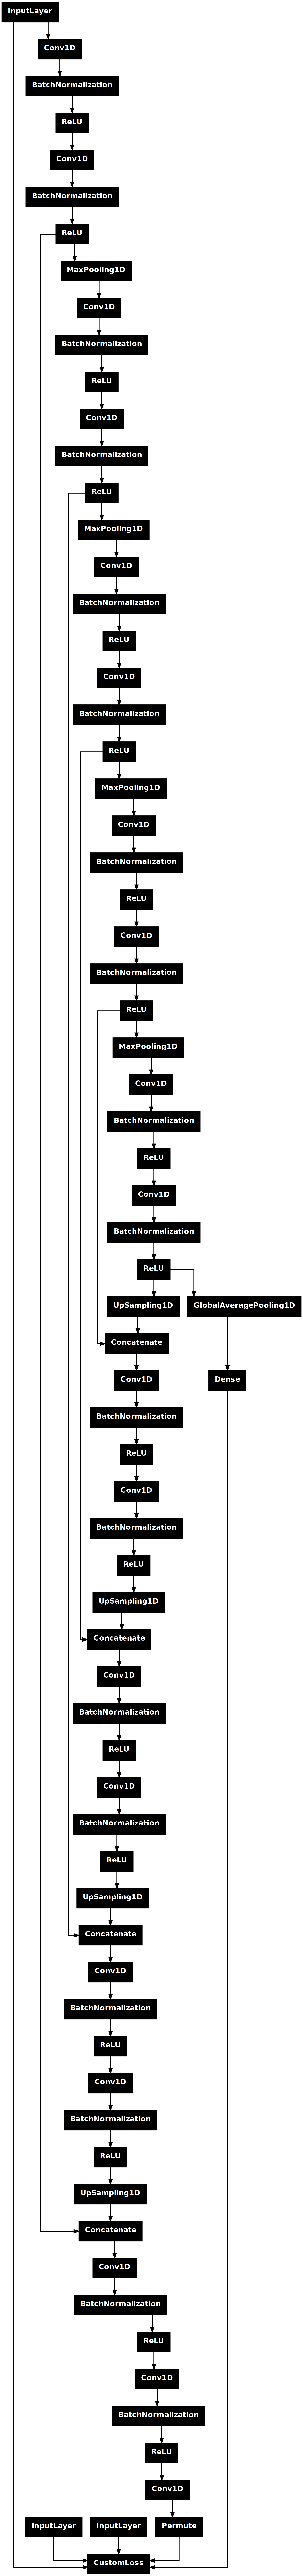

In [82]:
keras.utils.plot_model(model)

In [8]:
model.output

<KerasTensor shape=(), dtype=float32, sparse=False, name=keras_tensor_70>

In [12]:
file = tables.open_file('data.hdf5')

In [13]:
type(file)

tables.file.File

In [107]:
file.root.cs, file.root.cs[:]

(/cs (CArray(21,)shuffle, blosc:lz4hc(9)) ''
   atom := Float32Atom(shape=(), dflt=0.0)
   maindim := 0
   flavor := 'numpy'
   byteorder := 'little'
   chunkshape := (16384,),
 array([1500., 1550., 1600., 1650., 1700., 1750., 1800., 1850., 1900.,
        1950., 2000., 2050., 2100., 2150., 2200., 2250., 2300., 2350.,
        2400., 2450., 2500.], dtype=float32))

In [106]:
file.root.depths, file.root.depths[:]

(/depths (CArray(40,)shuffle, blosc:lz4hc(9)) ''
   atom := Float32Atom(shape=(), dflt=0.0)
   maindim := 0
   flavor := 'numpy'
   byteorder := 'little'
   chunkshape := (16384,),
 array([  25.,   50.,   75.,  100.,  125.,  150.,  175.,  200.,  225.,
         250.,  275.,  300.,  325.,  350.,  375.,  400.,  425.,  450.,
         475.,  500.,  525.,  550.,  575.,  600.,  625.,  650.,  675.,
         700.,  725.,  750.,  775.,  800.,  825.,  850.,  875.,  900.,
         925.,  950.,  975., 1000.], dtype=float32))

In [108]:
file.root.frequencies, file.root.frequencies[:]

(/frequencies (CArray(14,)shuffle, blosc:lz4hc(9)) ''
   atom := Float32Atom(shape=(), dflt=0.0)
   maindim := 0
   flavor := 'numpy'
   byteorder := 'little'
   chunkshape := (16384,),
 array([ 20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120.,
        130., 140., 150.], dtype=float32))

In [109]:
file.root.zs, file.root.zs[:]

(/zs (CArray(1024,)shuffle, blosc:lz4hc(9)) ''
   atom := Float32Atom(shape=(), dflt=0.0)
   maindim := 0
   flavor := 'numpy'
   byteorder := 'little'
   chunkshape := (16384,),
 array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.021e+03, 1.022e+03,
        1.023e+03], dtype=float32))

In [14]:
file.root.zs[:10], file.root.zs[-10:]

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32),
 array([1014., 1015., 1016., 1017., 1018., 1019., 1020., 1021., 1022.,
        1023.], dtype=float32))

In [111]:
file.root.rhos, file.root.rhos[:]

(/rhos (CArray(21,)shuffle, blosc:lz4hc(9)) ''
   atom := Float32Atom(shape=(), dflt=0.0)
   maindim := 0
   flavor := 'numpy'
   byteorder := 'little'
   chunkshape := (16384,),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
        2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ], dtype=float32))

In [ ]:
file.root.kj, file.root.kj[:]

In [13]:
file.root.phi

/phi (CArray(21, 21, 14, 40, 16, 1024)shuffle, blosc:lz4hc(9)) ''
  atom := Float16Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 1, 16, 16, 1024)

In [63]:
def create_dataset(
    data,
    batch_size=32,
    depth_step=1,
    seed=1580
):
    
    np.random.seed(seed)
    
    rhos = data.root.rhos[:]
    cs = data.root.cs[:]
    depths = data.root.depths[:]
    # phi = data.root.phi[:]
    # kj = data.root.kj[:]
    zs = data.root.zs[:]
        
    zs_subset = zs[::depth_step]
    len_zs = len(zs_subset)
        
    n_rho, n_cs, n_f, n_depth = data.root.phi.shape[:4]

    X_data = []
    y_modes = []
    y_waves = []

    for _ in tqdm.trange(batch_size):

        idx_rho, idx_cs, idx_depth = np.random.randint(0, [n_rho, n_cs, n_depth])
        idx_f = 8
        
        rho_bottom = rhos[idx_rho]
        cs_bottom = cs[idx_cs]
        depth_bottom = depths[idx_depth]
        
        X = np.zeros((len_zs, 3), dtype=np.float32)
        X[:, 0] = zs_subset
    
        water_mask = zs_subset < depth_bottom
        X[water_mask, 1] = 1500.0     
        X[water_mask, 2] = 1.0 
        X[~water_mask, 1] = cs_bottom
        X[~water_mask, 2] = rho_bottom
        
        y_mode = data.root.phi[idx_rho, idx_cs, idx_f, idx_depth, :, ::depth_step].astype(np.float32)
        y_wave = data.root.kj[idx_rho, idx_cs, idx_f, idx_depth, :].astype(np.float32)
        
        X_data.append(X)
        y_modes.append(y_mode)
        y_waves.append(y_wave)
        
    X_data = np.array(X_data)
    y_modes = np.array(y_modes)
    y_waves = np.array(y_waves)

    data_X = tf.data.Dataset.from_tensor_slices(X_data)
    data_y_m = tf.data.Dataset.from_tensor_slices(y_modes)
    data_y_w = tf.data.Dataset.from_tensor_slices(y_waves)

    y_loss = np.expand_dims(np.zeros(batch_size), axis=-1) 
    y_loss = tf.data.Dataset.from_tensor_slices(y_loss)
    
    dataset = tf.data.Dataset.zip(
        (
            tf.data.Dataset.zip(
                (data_X, data_y_m, data_y_w)
            ),
            y_loss
        )
    ).batch(batch_size)
    
    return dataset

In [64]:
dataset = create_dataset(file, batch_size=64, depth_step=1, seed=1580)

  0%|          | 0/64 [00:00<?, ?it/s]

In [65]:
dataset

<_BatchDataset element_spec=((TensorSpec(shape=(None, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 16, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None, 16), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [66]:
x, y = next(iter(dataset))

In [67]:
x[1][0]

<tf.Tensor: shape=(16, 1024), dtype=float32, numpy=
array([[ 0.        ,  0.00082016,  0.00164032, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.00164032,  0.00328064, ..., -0.        ,
        -0.        , -0.        ],
       [ 0.        ,  0.00246239,  0.00492096, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.01158905,  0.02294922, ..., -0.        ,
        -0.        , -0.        ],
       [ 0.        ,  0.01242828,  0.02455139, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.01325989,  0.02615356, ..., -0.        ,
        -0.        , -0.        ]], dtype=float32)>

In [69]:
def loss_c(y_true, y_pred):
    return keras.ops.mean(y_pred)

In [70]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=loss_c)

In [ ]:
model.fit(dataset, epochs=1000)

In [72]:
loss_f = model.predict(dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [73]:
loss_f

0.2500543

In [74]:
model_inputs = model.input 
modes_output = model.get_layer(get_name('Unet1D', "permute")).output

extraction_modes = keras.Model(inputs=model_inputs, outputs=modes_output)

In [75]:
modes_features = []

for batch in dataset:
    inputs = batch[0]
    modes_feature = extraction_modes(inputs)
    modes_features.append(modes_feature)

modes_features = tf.concat(modes_features, axis=0)

2025-03-03 22:27:42.879123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [76]:
modes_features.shape

TensorShape([64, 16, 1024])

In [77]:
modes_features[0]

<tf.Tensor: shape=(16, 1024), dtype=float32, numpy=
array([[ 0.00742172, -0.07980615,  0.36624408, ..., -1.4796673 ,
        -0.5483894 ,  0.03620607],
       [ 0.01650544,  1.1467478 ,  0.9986321 , ...,  0.04959515,
        -0.65790534, -0.04177948],
       [-0.02259495, -0.40876347,  0.2998557 , ...,  0.3163413 ,
         0.01043355, -0.00745335],
       ...,
       [-0.02147938,  0.40105265,  0.26522347, ..., -0.19510914,
        -0.19562583, -0.02353538],
       [ 0.00467931, -0.6259845 ,  0.09693049, ...,  0.14907125,
         0.27400944,  0.0245339 ],
       [ 0.0247583 ,  0.7945913 ,  0.8964058 , ...,  0.33030322,
         0.3375957 ,  0.01796689]], dtype=float32)>

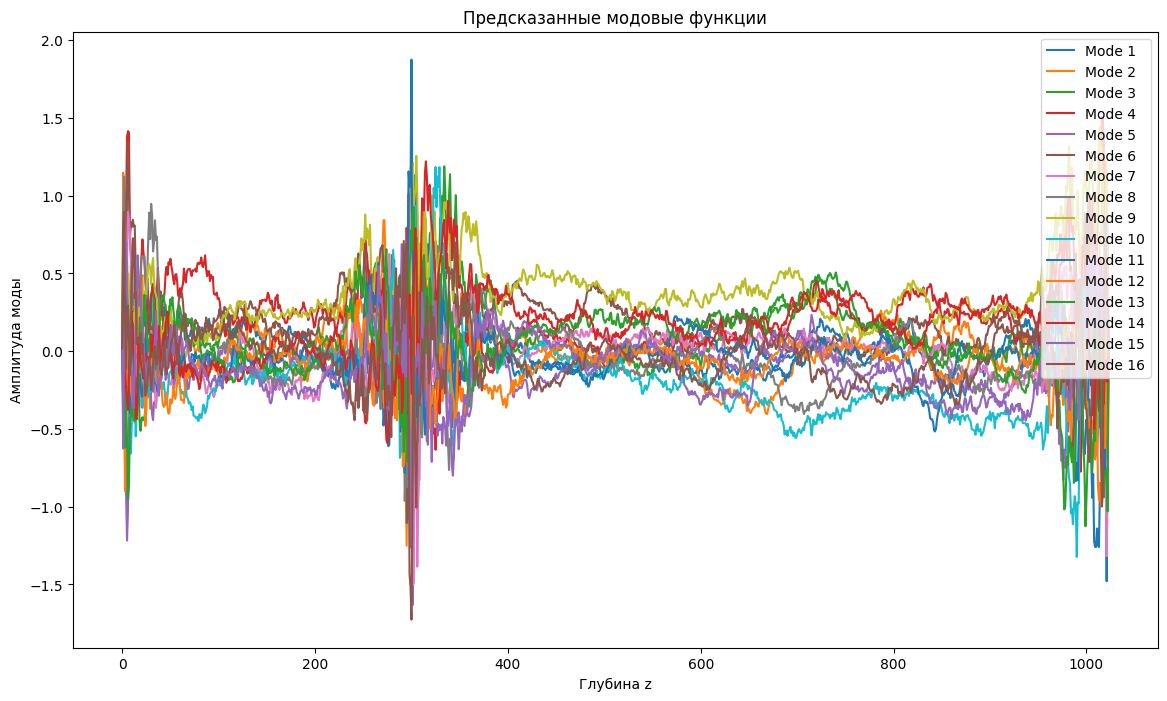

In [79]:
z = file.root.zs[:]

plt.figure(figsize=(14, 8))
for i in range(num_modes):
    plt.plot(z, modes_features[0][i, :], label=f"Mode {i+1}")
plt.xlabel("Глубина z")
plt.ylabel("Амплитуда моды")
plt.title("Предсказанные модовые функции")
plt.legend()
plt.show()

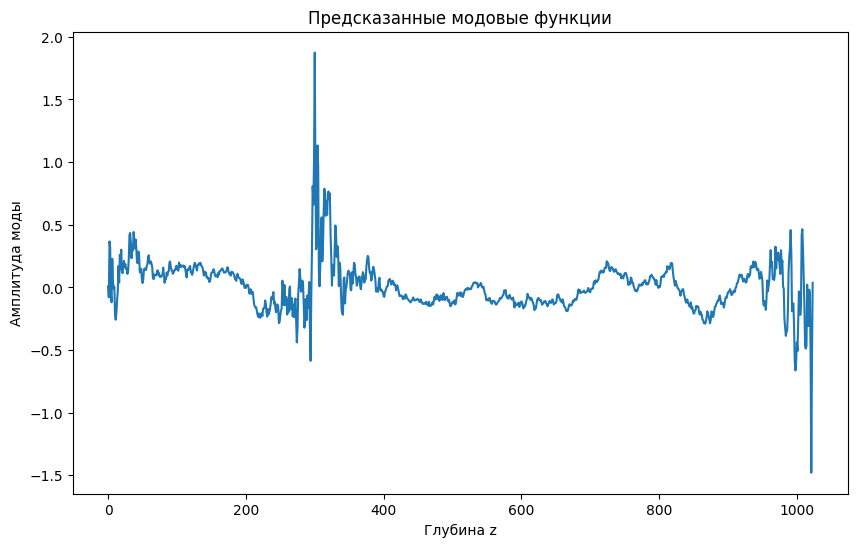

In [81]:
plt.figure(figsize=(10, 6))

plt.plot(z, modes_features[0][0, :])
plt.xlabel("Глубина z")
plt.ylabel("Амплитуда моды")
plt.title("Предсказанные модовые функции")
plt.show()